© Alexander Jüstel, Fraunhofer IEG, Institution for Energy Infrastructures and Geothermal Systems, RWTH Aachen University,
GNU Lesser General Public License v3.0

# 07 Processing Data Type 3 - Point Addresses

This notebook illustrates how to process data of Data Type 3 - Point Addresses. The input data is provided as CSV file containing the heat demand, the street name, the house number, the postal code, and the city all in different columns.

## Importing Libraries

In [1]:
import rasterio
from rasterio.plot import show
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

from pyheatdemand import processing 

C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Loading Sample Data

The sample data is loaded using `GeoPandas`. Some minor manipulations for further processing are performed as well. 

In [2]:
data = pd.read_csv('../../../test/data/Data_Type_III_Point_Addresses.csv')
data['PLZ'] = data['PLZ'].astype(int)
data['Strasse'] = data['Strasse'].apply(lambda x: ''.join(' ' + char if char.isupper() else char for char in x).strip())
data.head()

,Unnamed: 0,HeatDemand,Strasse,Nummer,PLZ,Ort
0,0,431905.208696,Rathausplatz,1,59174,Kamen
1,1,1858.465217,Rathausplatz,1,59174,Kamen
2,2,28594.673913,Rathausplatz,4,59174,Kamen
3,3,15952.934783,Am Schwimmbad,5,59174,Kamen
4,4,7.173913,Hammer Straße,19,59174,Kamen


## Getting coordinates of Addresses

The addresses as point geometries are obtained using the function `obtain_coordinates_from_addresses`. We continue working with a subset of 500 addresses.

**NB: Be adviced that there may be a timeout when trying to get too many addresses at once. You may have to split the data into several parts.**

In [3]:
gdf_addresses = gpd.read_file('../../../test/data/Data_Type_III_Point_Addresses.shp')

In [4]:
gdf_addresses

,Unnamed_ 0,HeatDemand,Strasse,Nummer,PLZ,Ort,address,geometry
0,0,431905.208696,Rathausplatz,1,59174,Kamen,Rathausplatz 1 59174 Kamen,POINT (3843562.447 2758094.896)
1,1,1858.465217,Rathausplatz,1,59174,Kamen,Rathausplatz 1 59174 Kamen,POINT (3843562.447 2758094.896)
2,2,28594.673913,Rathausplatz,4,59174,Kamen,Rathausplatz 4 59174 Kamen,POINT (3843569.733 2758193.784)
3,3,15952.934783,Am Schwimmbad,5,59174,Kamen,Am Schwimmbad 5 59174 Kamen,POINT (3843246.774 2758158.914)
4,4,7.173913,Hammer Straße,19,59174,Kamen,Hammer Straße 19 59174 Kamen,POINT (3843906.050 2759006.465)
...,...,...,...,...,...,...,...,...
495,495,20258.152174,Markt,2,59174,Kamen,Markt 2 59174 Kamen,POINT (3843712.612 2758570.505)
496,496,5420.760870,Markt,20,59174,Kamen,Markt 20 59174 Kamen,POINT (3843718.474 2758650.486)
497,497,178.804348,Markt,10,59174,Kamen,Markt 10 59174 Kamen,POINT (3843783.485 2758610.457)
498,498,0.000000,Markt,24,59174,Kamen,Markt 24 59174 Kamen,POINT (3843675.336 2758613.473)


## Getting Building Footprints based on Building Coordinates

The function `get_building_footprints` returns a GeoDataFrame consisting of the `Shapely` Polygon of each building that is present at the provided coordinates. The `dist` parameter may be adjusted to get all buildings. By default, a spatial join is performed for the addresses and building footprints to filter out additional not needed footprints.

In [5]:
gdf_buildings = gpd.read_file('../../../test/data/Data_Type_III_Building_Footprints.shp')
gdf_buildings

,HeatDemand,geometry
0,1858.465217,"POLYGON ((3843565.679 2758055.079, 3843560.344..."
1,1858.465217,"POLYGON ((3843565.679 2758055.079, 3843560.344..."
2,431905.208696,"POLYGON ((3843565.679 2758055.079, 3843560.344..."
3,431905.208696,"POLYGON ((3843565.679 2758055.079, 3843560.344..."
4,28594.673913,"POLYGON ((3843560.850 2758192.194, 3843561.876..."
...,...,...
3157,0.000000,"POLYGON ((3843674.414 2758615.228, 3843680.744..."
3158,0.000000,"POLYGON ((3843674.414 2758615.228, 3843680.744..."
3159,20258.152174,"POLYGON ((3843707.635 2758578.284, 3843717.888..."
3160,5420.760870,"POLYGON ((3843717.886 2758642.017, 3843710.028..."


Text(132.72222222222223, 0.5, 'Y [m]')

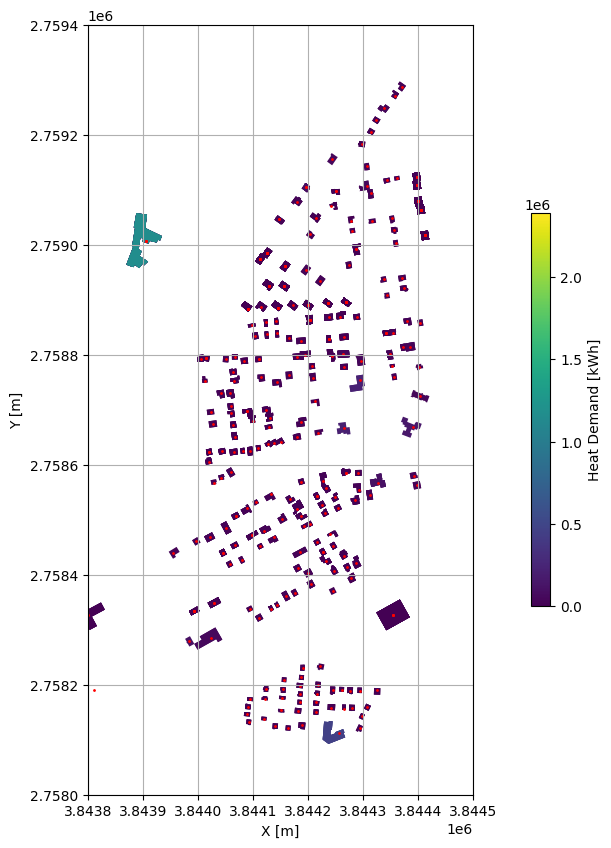

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
gdf_buildings.plot(ax=ax, column='HeatDemand', legend=True, legend_kwds={'shrink':0.51, 'label': 'Heat Demand [kWh]'})
gdf_addresses.plot(ax=ax, color='red', markersize=1)
plt.xlim(3.8438e6, 3.8445e6)
plt.ylim(2.7580e6, 2.7594e6)
plt.grid()

plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Inspect CRS

We are inspecting the CRS and see that is does not match with the desired CRS `EPSG:3034`.

In [7]:
data = gdf_addresses

In [8]:
data.crs

<Projected CRS: EPSG:3034>
Name: ETRS89-extended / LCC Europe
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Conformal 2001
- method: Lambert Conic Conformal (2SP)
Datum: Euro

## Creating GeoDataFrame Outline from vectorized Raster

For further processing, we are creating an outline `GeoDataFrame` from the `total_bounds` of the vectorized raster.

In [9]:
gdf = processing.create_outline(data)
gdf

,geometry
0,"POLYGON ((3851560.901 2758094.896, 3851560.901..."


## Loading Interreg Mask

We are loading the previously created 10 km mask. 

In [10]:
mask_10km = gpd.read_file('../../../test/data/Interreg_NWE_mask_10km_3034.shp')
mask_10km

,FID,geometry
0,0,"POLYGON ((2651470.877 2955999.353, 2651470.877..."
1,1,"POLYGON ((2651470.877 2965999.353, 2651470.877..."
2,2,"POLYGON ((2651470.877 2975999.353, 2651470.877..."
3,3,"POLYGON ((2651470.877 2985999.353, 2651470.877..."
4,4,"POLYGON ((2651470.877 2995999.353, 2651470.877..."
...,...,...
9225,9225,"POLYGON ((4141470.877 2605999.353, 4141470.877..."
9226,9226,"POLYGON ((4141470.877 2615999.353, 4141470.877..."
9227,9227,"POLYGON ((4151470.877 2585999.353, 4151470.877..."
9228,9228,"POLYGON ((4151470.877 2595999.353, 4151470.877..."


In [11]:
mask_10km.crs

<Projected CRS: EPSG:3034>
Name: ETRS89-extended / LCC Europe
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Conformal 2001
- method: Lambert Conic Conformal (2SP)
Datum: Euro

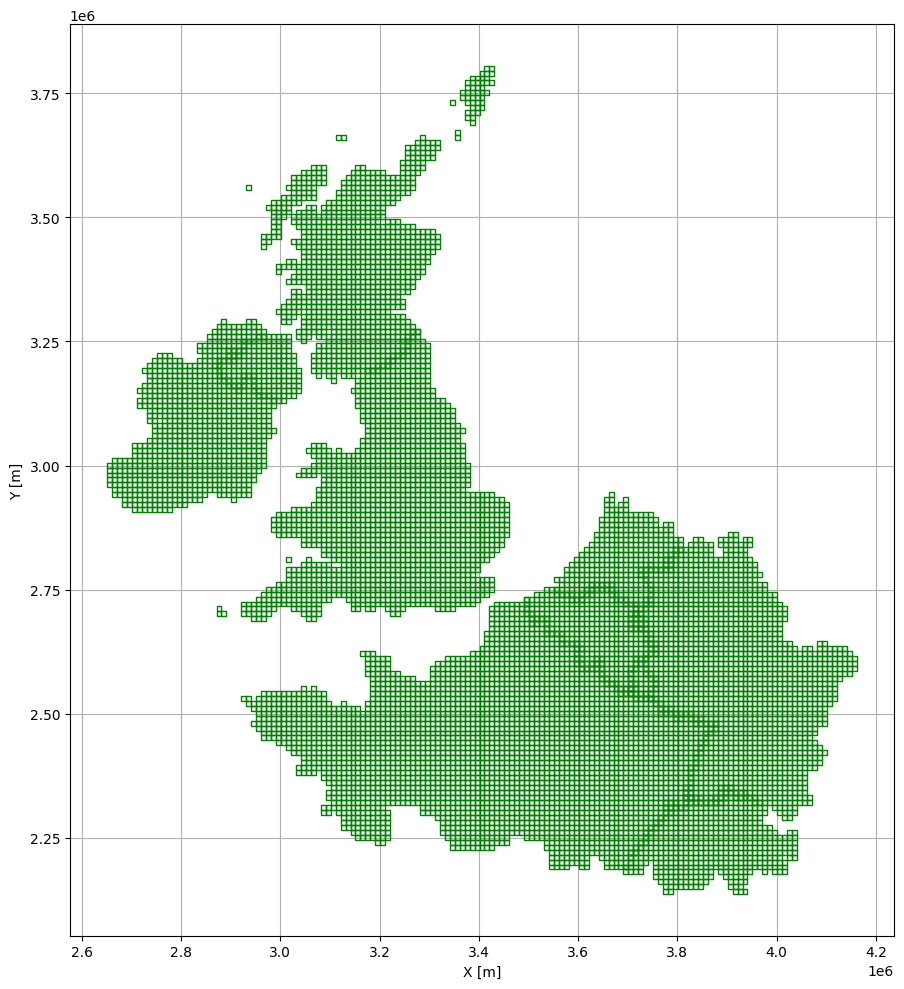

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
mask_10km.boundary.plot(ax=ax, linewidth=1, color='green')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

## Crop Mask to Data Limits

The 10 km cells that intersect with the data outline are selected. 

In [13]:
mask_10km_cropped = mask_10km.sjoin(gdf).reset_index()[['geometry']]
mask_10km_cropped

,geometry
0,"POLYGON ((3831470.877 2755999.353, 3831470.877..."
1,"POLYGON ((3841470.877 2755999.353, 3841470.877..."
2,"POLYGON ((3851470.877 2755999.353, 3851470.877..."


## Plotting the Cropped Mask

The cropped mask and the data outline are plotted using `matplotlib`. 

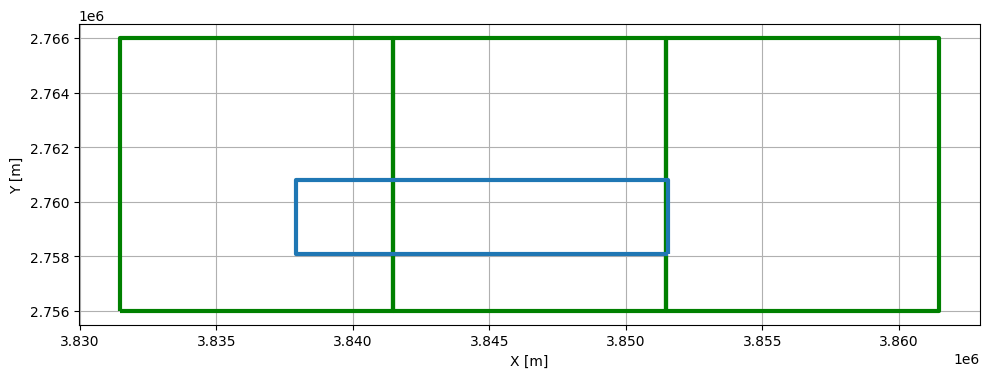

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
mask_10km_cropped.boundary.plot(ax=ax, linewidth=3, color='green')
gdf.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=3)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

## Creating mask from cropped mask

Here, the final mask with a width and height of 100 m is created. 

In [15]:
mask_100m_cropped = processing.create_polygon_mask(gdf=mask_10km_cropped, 
                                                   step_size=100,
                                                   crop_gdf=True)
mask_100m_cropped

,geometry
0,"POLYGON ((3831470.877 2755999.353, 3831570.877..."
1,"POLYGON ((3831470.877 2756099.353, 3831570.877..."
2,"POLYGON ((3831470.877 2756199.353, 3831570.877..."
3,"POLYGON ((3831470.877 2756299.353, 3831570.877..."
4,"POLYGON ((3831470.877 2756399.353, 3831570.877..."
...,...
30395,"POLYGON ((3861370.877 2765499.353, 3861470.877..."
30396,"POLYGON ((3861370.877 2765599.353, 3861470.877..."
30397,"POLYGON ((3861370.877 2765699.353, 3861470.877..."
30398,"POLYGON ((3861370.877 2765799.353, 3861470.877..."


## Cropping Mask to outline

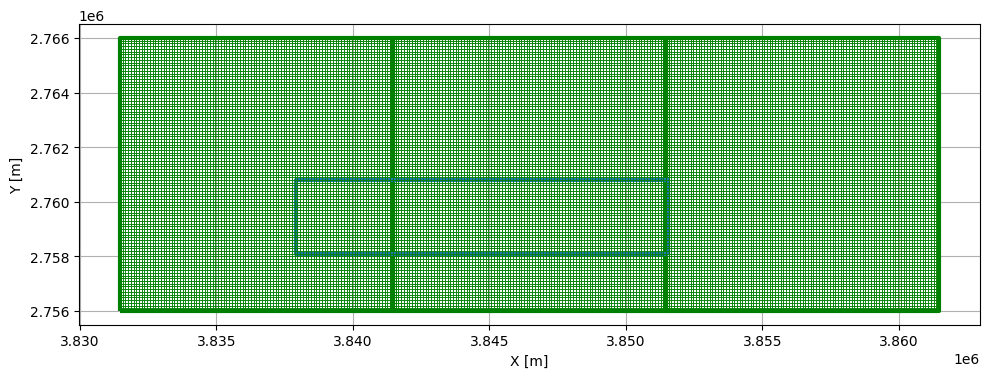

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
mask_10km_cropped.boundary.plot(ax=ax, linewidth=3, color='green')
gdf.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=3)
mask_100m_cropped.boundary.plot(ax=ax, linewidth=0.5, color='green')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

#plt.savefig('../images/Data_Type_1_Outline.png', dpi=300)

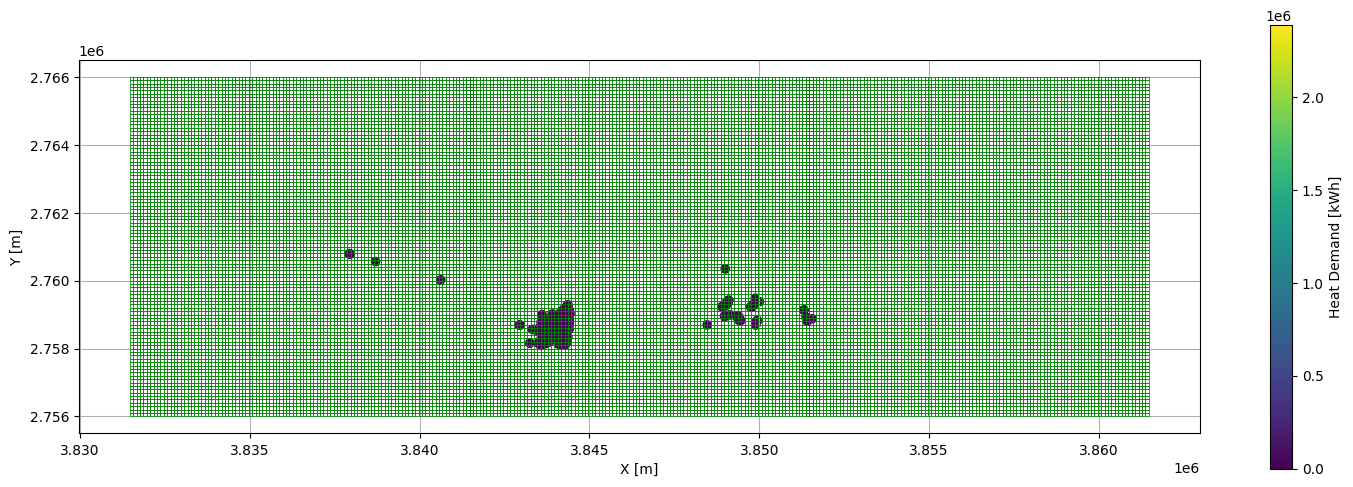

In [17]:
fig, ax = plt.subplots(figsize=(15,9))

mask_100m_cropped.boundary.plot(ax=ax, linewidth=0.5, color='green')
data.plot(ax=ax, column='HeatDemand', legend=True, legend_kwds={'shrink':0.51, 'label': 'Heat Demand [kWh]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

## Calculate Heat Demand

With the vectorized raster and the 100 m mask, we can now directly calculate the heat demand using `calculate_hd`. 

In [18]:
hd_gdf = data
mask_gdf = mask_100m_cropped

In [19]:
gdf_hd = processing.calculate_hd(hd_gdf, 
                                 mask_gdf, 
                                 'HeatDemand')
gdf_hd 

,HD,geometry
0,17713.865217,"POLYGON ((3837870.877 2760699.353, 3837970.877..."
1,5594.678261,"POLYGON ((3838670.877 2760499.353, 3838770.877..."
2,4948.586957,"POLYGON ((3840570.877 2759999.353, 3840670.877..."
3,263325.665217,"POLYGON ((3842870.877 2758599.353, 3842970.877..."
4,15952.934783,"POLYGON ((3843170.877 2758099.353, 3843270.877..."
...,...,...
91,14646.739130,"POLYGON ((3849970.877 2759299.353, 3850070.877..."
92,10162.439130,"POLYGON ((3851270.877 2759099.353, 3851370.877..."
93,6966.956522,"POLYGON ((3851370.877 2758799.353, 3851470.877..."
94,30115.417391,"POLYGON ((3851370.877 2758899.353, 3851470.877..."


Text(70.22222222222221, 0.5, 'Y [m]')

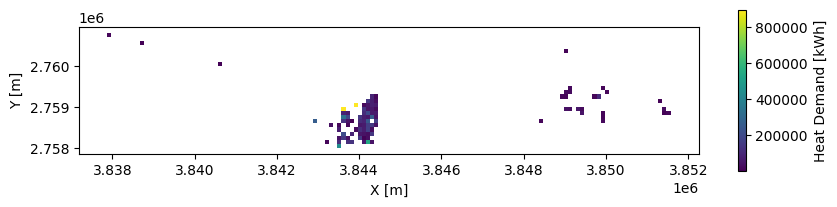

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

gdf_hd.plot(ax=ax,column='HD', vmax=900000, legend=True, legend_kwds={'shrink':0.21, 'label': 'Heat Demand [kWh]'})

plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Rasterizing Vector Data

The vector data will be rasterized and saved to file.

In [21]:
processing.rasterize_gdf_hd(gdf_hd, 
                     path_out='../../../test/data/Data_Type_III_Point_Addresses.tif',
                     crs = 'EPSG:3034', 
                     xsize = 100,
                     ysize = 100,
                     flip_raster=True)

## Opening and plotting raster
The final raster can now be opened and plotted. 

In [22]:
raster = rasterio.open('../../../test/data/Data_Type_III_Point_Addresses.tif')

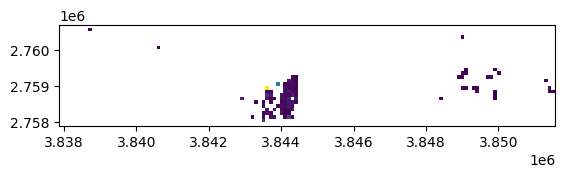

<Axes: >

In [23]:
show(raster)